<a href="https://colab.research.google.com/github/jorell1/PyLZJD_Jupyter/blob/master/Implementing_LZJDh%2C_test_on_Shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing LZJD and LZJDh in Clustering Shakespeare

LZJD is a method for computing a similarity measure between arbitrary files.  LZJD, and its faster variation LZJDh, were inspired by the compression-based similarity funtion NCD described by Li in 2004.

Here's some code that I need to put into all my Python notebooks...

In [ ]:
import datetime
import numpy as np
import pickle
import sys
import time

from LZJD import *
from os import chdir
from os import getcwd
from os import path
"""
print(str(datetime.datetime.now()))
if path.exists('/home/charles'):
    # for my Linux laptop
    home = '/home/charles/'
    dropBoxDir = home+'Dropbox/'
elif path.exists('/home/nicholas'):
    # for dream-lab
    home = '/home/nicholas/'
    dropBoxDir = home+'Dropbox/'
elif path.exists('C:/Users/nicho'):
    print("Windows 10 laptop")
    home = '/Users/nicho/'
    dropBoxDir = home+'Dropbox/'
elif path.exists('/Users/charles'):
    print("Office Mac")
    # for the Mac in my office
    home = '/Users/charles/'
    dropBoxDir = '/Volumes/MyBook/Dropbox/'
else:
    print('Cannot figure out home directory')

print('Dropbox is at %s' % dropBoxDir)
print("home is %s" % home)"""

'\nprint(str(datetime.datetime.now()))\nif path.exists(\'/home/charles\'):\n    # for my Linux laptop\n    home = \'/home/charles/\'\n    dropBoxDir = home+\'Dropbox/\'\nelif path.exists(\'/home/nicholas\'):\n    # for dream-lab\n    home = \'/home/nicholas/\'\n    dropBoxDir = home+\'Dropbox/\'\nelif path.exists(\'C:/Users/nicho\'):\n    print("Windows 10 laptop")\n    home = \'/Users/nicho/\'\n    dropBoxDir = home+\'Dropbox/\'\nelif path.exists(\'/Users/charles\'):\n    print("Office Mac")\n    # for the Mac in my office\n    home = \'/Users/charles/\'\n    dropBoxDir = \'/Volumes/MyBook/Dropbox/\'\nelse:\n    print(\'Cannot figure out home directory\')\n\nprint(\'Dropbox is at %s\' % dropBoxDir)\nprint("home is %s" % home)'

As an example of LaTeX in a Jupyter notebook,
$$
NCD(a,b) = \frac{C(ab)-min(C(a),C(b))}{max(C(a),C(b))}
$$
where $ab$ is the concatenation of strings $a$ and $b$, and $C(x)$ is the length of string $x$ is compressed.

Nicholas and Stout (Charles Nicholas and Kevin Stout, “ Experience with Compression-Based Distance Metrics for Malware”, presented at Malware Technical Exchange Meeting, August 14-16, 2012 (poster session)) suggested using just the strings generated by compression, which we call the LZset.

The LZJD metric is simply the Jaccard similarity between the lzsets of the two operand strings.  Since Jaccard similarity is known to be a metric, satisfying the three metric properties, LZJD is a metric as well.  The set intersection operation in the numerator is O(n log n), but Python's built-in set intersection function is fast enough.  If the objects are big enough to make it a concern, we should be using LZJDh anyway.

The entries in the LZSet are the same, I think, whether using LZJD or LZJDh.

The idea of LZJDh is to represent the LZSet of a string as a vector of fixed size, perhaps 1000, constructed as follows.

Build the LZSet of object x as usual.  For each string in the LZSet, use a hash function to compute a corresponding hash value.  Keep track of the 1000 (or maybe 2000) smallest values thereby computed.  Sort the list of smallest values, and keep that sorted list of integers as the representative of object x.  Being stored in SortedSets, the intersection of two such lists of integers is I hope computed in linear time.

The first two values should be 0, and the third close to 0.33

In [ ]:
lz2= lzset(b"abab", verbose=False)
lz1= lzset(b"ababbaa", verbose=False)
#lz3.lzstats()
#lz3.test()
#lz3.print()
#lz2 = lzset(b"to be or not to be since when do I care?")
#lz2.lzstats()
print(lz1.lzjd(lz1), lz2.lzjd(lz2), lz1.lzjd(lz2))
print(lz1.sharedStrings(lz2))

0.0 0.0 0.33333333333333337
[b'ba', b'ab', b'b', b'a']


In [ ]:
lz1 = lzset(b"to be or not to be that is the question")
lz2 = lzset(b"to be or not to be since when do I care?")
print(lz1.lzjd(lz1), lz2.lzjd(lz2), lz1.lzjd(lz2))
print(lz1.lzjdh(lz1), lz2.lzjdh(lz2), lz1.lzjdh(lz2))

0.0 0.0 0.6029411764705883
0.0 0.0 0.6029411764705883


When the input objects are short, and the number of distinct hash values computed is 1000 or less, LZJD and LZJDh are equal.  When the input objects are longer, the approximation starts to take effect.

To see if all this works in Jupyter, let's play with the Shakespeare corpus.  I'll provide a tarfile with the email.  You need to modify the variable wd below, depending on where you untar that file.

In [ ]:
#wd = dropBoxDir+"working/vx/"
dataDir = "C:\\Users\\student\\Desktop\\clusteringshakespearewithlzjd\\WSzipped\\WS\\"

import os, glob
from os.path import isfile, join
from pyLZJD import sim, digest

text_files = glob.glob(join(dataDir, "*.txt"))
#text_files = [f for f in os.listdir(dataDir) if f.endswith('.txt')]
#print(text_files)
n = len(text_files)
result = digest(text_files)


computing similarity matrix row 1/37 (C:\Users\student\Desktop\clusteringshakespearewithlzjd\WSzipped\WS\AllsWell.txt)


IndexError: list assignment index out of range

Now compute the lzsets.  This needs to be done only once.  The lzset can be thought of as a set of strings such that all the strings occur in the lzset can be concatenedated, in some order and with the given amount of repetiton, to recreate the original document.  Also, each string in the lzset does occur in the document at least once, but if the frequency is zero, the string DOES occur at least once.  It was just not needed for the sake of LZ compression.  

In [ ]:
#read in a bunch of files
buff = [open(dataDir+f, "rb").read() for f in text_files]

#taking up how much space?
buffSize = 0
for i in range(n):
    buffSize += len(buff[i])
print("Raw data takes up how much space? %d" % (buffSize))

OSError: [Errno 22] Invalid argument: 'C:\\Users\\student\\Desktop\\clusteringshakespearewithlzjd\\WSzipped\\WS\\C:\\Users\\student\\Desktop\\clusteringshakespearewithlzjd\\WSzipped\\WS\\AllsWell.txt'

In [ ]:
start = time.clock()
nullLZset = lzset(b"")
lzSets = [nullLZset for i in range(n)]

start = time.clock()
for i in range(n):
    print("Building lzset for %s" % (text_files[i]))
    lzSets[i] = lzset(buff[i])
print("Execution time for building LZSets: %f" % (time.clock() - start))

c:\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
c:\python37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


Building lzset for AllsWell.txt
Building lzset for AnthonyAndCleo.txt
Building lzset for AsYouLikeIt.txt
Building lzset for ComedyOfErrors.txt
Building lzset for Coriolanus.txt
Building lzset for Cymbeline.txt
Building lzset for Hamlet.txt
Building lzset for Henry4Part1.txt
Building lzset for Henry4Part2.txt
Building lzset for Henry5.txt
Building lzset for Henry6Part1.txt
Building lzset for Henry6Part2.txt
Building lzset for Henry6Part3.txt
Building lzset for Henry8.txt
Building lzset for JuliusCaesar.txt
Building lzset for KingJohn.txt
Building lzset for KingLear.txt
Building lzset for LoveLabors.txt
Building lzset for Macbeth.txt
Building lzset for Measure4Measure.txt
Building lzset for MerchantOfVenice.txt
Building lzset for MerryWives.txt
Building lzset for MidsummerNights.txt
Building lzset for MuchAdo.txt
Building lzset for Othello.txt
Building lzset for Pericles.txt
Building lzset for Richard2.txt
Building lzset for Richard3.txt
Building lzset for RomeoJuliet.txt
Building lzset 

c:\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


In [ ]:
#build a similarity matrix for use in hierarchical clustering
# sim2 will be upper triangular only!
nchoose2 = n*(n-1)//2
print("Number of files is %d" % n)
print("Number of pairs (n choose 2) is %d" % nchoose2)
dataDir = "C:\\Users\\student\\Desktop\\clusteringshakespearewithlzjd\\WSzipped\\WS\\"

import os, glob
from os.path import isfile, join
from pyLZJD import sim, digest

text_files = glob.glob(join(dataDir, "*.txt"))
#text_files = [f for f in os.listdir(dataDir) if f.endswith('.txt')]
#print(text_files)
n = len(text_files)
result = digest(text_files)

sim2 = np.zeros(nchoose2)
k = 0
shortestD = 100
f1 = f2 = ""
ishort = jshort = -1

for i in range(n-1):
    print("computing similarity matrix row %d/%d (%s)" % (i+1, n, text_files[i]))
    for j in range(i+1,n):
        theDistance = sim(result[i],result[j])
        sim2[k] = theDistance
        if  theDistance < shortestD:
            shortestD = theDistance
            f1 = text_files[i]
            ishort = i
            f2 = text_files[j]
            jshort = j
            print("Closest files so far, with distance of %f (%d, %d): %s and %s" % 
                  (theDistance, ishort, jshort, f1, f2))
        k += 1

Number of files is 37
Number of pairs (n choose 2) is 666
computing similarity matrix row 1/37 (C:\Users\student\Desktop\clusteringshakespearewithlzjd\WSzipped\WS\AllsWell.txt)
Closest files so far, with distance of 0.184500 (0, 1): C:\Users\student\Desktop\clusteringshakespearewithlzjd\WSzipped\WS\AllsWell.txt and C:\Users\student\Desktop\clusteringshakespearewithlzjd\WSzipped\WS\AnthonyAndCleo.txt
Closest files so far, with distance of 0.149916 (0, 3): C:\Users\student\Desktop\clusteringshakespearewithlzjd\WSzipped\WS\AllsWell.txt and C:\Users\student\Desktop\clusteringshakespearewithlzjd\WSzipped\WS\ComedyOfErrors.txt
computing similarity matrix row 2/37 (C:\Users\student\Desktop\clusteringshakespearewithlzjd\WSzipped\WS\AnthonyAndCleo.txt)
Closest files so far, with distance of 0.141583 (1, 3): C:\Users\student\Desktop\clusteringshakespearewithlzjd\WSzipped\WS\AnthonyAndCleo.txt and C:\Users\student\Desktop\clusteringshakespearewithlzjd\WSzipped\WS\ComedyOfErrors.txt
Closest files 

In [ ]:
print("According to LZJD, the two closest plays are (%d, %d): %s and %s, with a distance of %f" 
      % (ishort, jshort, f1, f2, shortestD))

According to LZJD, the two closest plays are (3, 8): C:\Users\student\Desktop\clusteringshakespearewithlzjd\WSzipped\WS\ComedyOfErrors.txt and C:\Users\student\Desktop\clusteringshakespearewithlzjd\WSzipped\WS\Henry4Part2.txt, with a distance of 0.124040


Yes!  This makes sense!  For the following, you need to install the plotly package.

In [ ]:
import plotly
import plotly.plotly as py

#
# if plotly isn't found, use conda to install it so jupyter can find it
# something like ./conda install -c plotly plotly
# may need to sudo into /opt/anaconda/bin
#
import plotly.graph_objs as go

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print( __version__) # requires version >= 1.9.0
plotly.tools.set_credentials_file(username='cknicholas', 
                                  api_key='pa9Z110GEeh029O4jTV0')
init_notebook_mode(connected=True)
#
# see if plotly is usable in this notebook
#
#iplot([{"x": [1, 2, 3], "y": [3, 1, 6]}])

ModuleNotFoundError: No module named 'plotly'

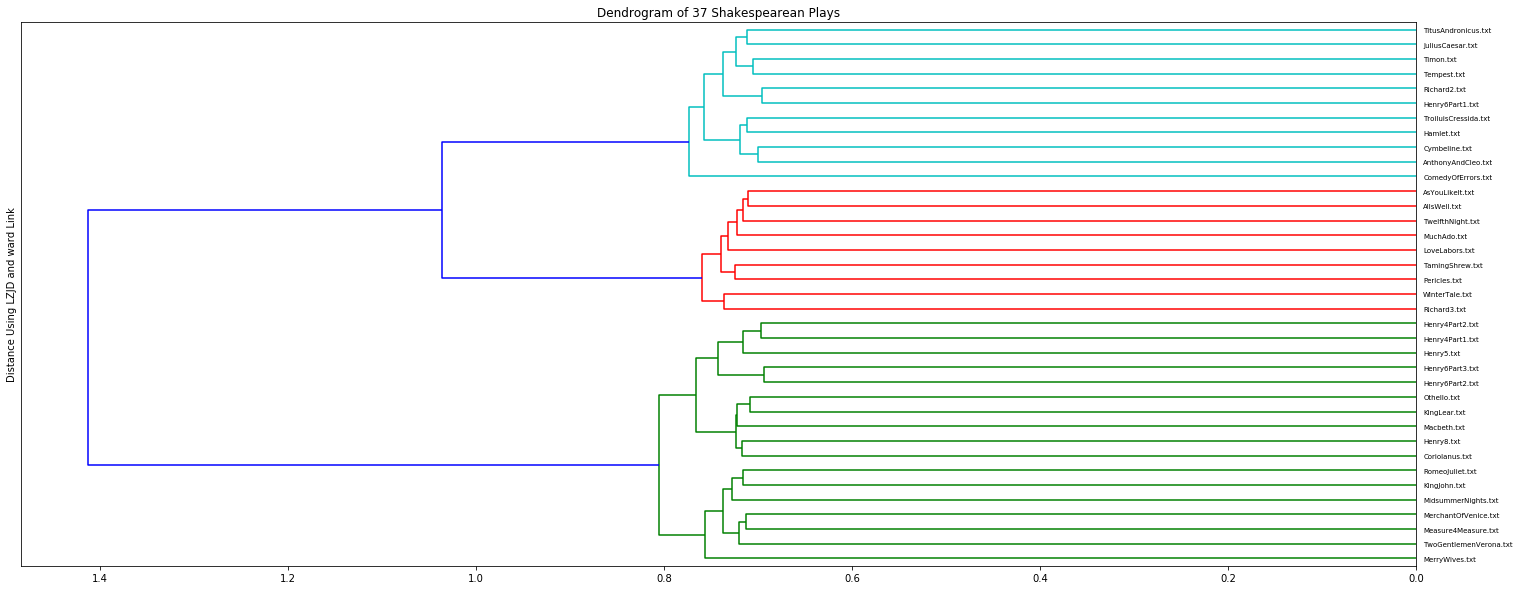

In [ ]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

plt.figure(1, figsize=(25, 10))
plt.clf()
plt.title("Dendrogram of %d Shakespearean Plays" % n)

possible_methods = ["single", "complete", "average", "weighted",
                    "centroid", "median", "ward"]
method = possible_methods[6]
plt.ylabel("Distance Using LZJD and %s Link" % (method))
linkage_matrix = linkage(sim2, method)

dendrogram(
    linkage_matrix,
    orientation='left',
    labels=text_files,
    #leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=7.,  # font size for the x axis labels
)
plt.show()

Granted that Henry 6 parts 2 and 3 are the most similar plays.  What strings do that have in common?  

In [ ]:
text_files[11]

'Henry6Part2.txt'

In [ ]:
text_files[12]

'Henry6Part3.txt'

In [ ]:
lzSets[11].sharedStrings(lzSets[12])

[b'\r\n\r\n   King. Wha',
 b'\r\n\r\n   Yorke. M',
 b'\r\n\r\n   King. Wh',
 b'\r\n\r\n   Yorke. T',
 b'\r\n\r\n   King. We',
 b'\r\n\r\n   Warw. M',
 b'\r\n\r\n   King. S',
 b'\r\n\r\n   Yorke. ',
 b'\r\n\r\n   King. W',
 b'\r\n\r\n   King. H',
 b'\r\n\r\n   King. L',
 b'\r\n\r\n   King. N',
 b'\r\n\r\n   King. M',
 b'\r\n\r\n   King. A',
 b'\r\n\r\n   King. C',
 b'\r\n\r\n   Warw. ',
 b'\r\n\r\n   King. ',
 b'\r\n\r\n   Yorke.',
 b'\r\n\r\n   Clif. ',
 b'\r\n\r\n   Queene',
 b'\r\n\r\n   Queen.',
 b'.\r\nEnter.\r\n\r',
 b'\n\r\n   King. ',
 b'\r\n\r\n   Yorke',
 b'.\r\nEnter a M',
 b'\r\n\r\n   Queen',
 b'\r\n\r\n   King.',
 b'\r\n\r\n   Qu. N',
 b'\r\n\r\n   Clif.',
 b'\r\n\r\n   Qu. T',
 b'\r\n\r\n   Warw.',
 b'\r\n\r\n   War. ',
 b'Soueraigne ',
 b'.\r\n\r\n  War.',
 b'\r\n\r\n   War.',
 b'shall be my',
 b'\n\r\n   War. ',
 b' with the B',
 b'.\r\n\r\nExeunt',
 b'\r\n\r\n   Qu. ',
 b'.\r\nEnter.\r\n',
 b'\r\n\r\n   York',
 b'\r\n   King. ',
 b'\r\n\r\n   Clif',
 b'\r\n\r\n   Som.'

So it seems that these two plays are considered similar because the same characters, notably the King and Yorke, speak a number of lines.   